In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import os


In [2]:

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
test_dir = r"D:\My Projects\Plant_Disease_Prediction_Custom_CNN\dataset_split\test"
classes = sorted([d.name for d in Path(test_dir).iterdir()])
num_classes = len(classes)

# Transforms
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load dataset
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:

# Your Custom CNN (must match architecture used during training)
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [4]:

# Load model
model = CustomCNN(num_classes).to(device)
model.load_state_dict(torch.load("best_custom_cnn.pth"))
model.eval()

# Predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


C:\Users\coder\AppData\Local\Temp\ipykernel_8100\2697313997.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_custom_cnn.pth"))


C:\Users\coder\AppData\Local\Temp\ipykernel_8100\2043340631.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Software\Anaconda\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


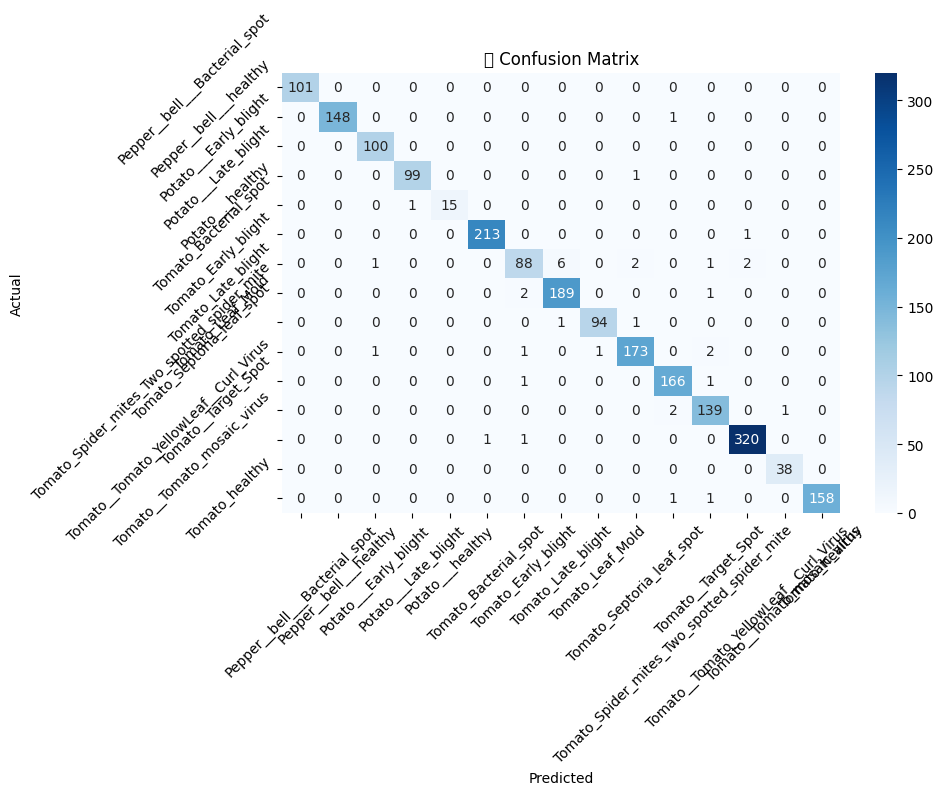

In [5]:

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('📊 Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()



🧾 Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       101
                     Pepper__bell___healthy       1.00      0.99      1.00       149
                      Potato___Early_blight       0.98      1.00      0.99       100
                       Potato___Late_blight       0.99      0.99      0.99       100
                           Potato___healthy       1.00      0.94      0.97        16
                      Tomato_Bacterial_spot       1.00      1.00      1.00       214
                        Tomato_Early_blight       0.95      0.88      0.91       100
                         Tomato_Late_blight       0.96      0.98      0.97       192
                           Tomato_Leaf_Mold       0.99      0.98      0.98        96
                  Tomato_Septoria_leaf_spot       0.98      0.97      0.97       178
Tomato_Spider_mites_Two_spotted_spide

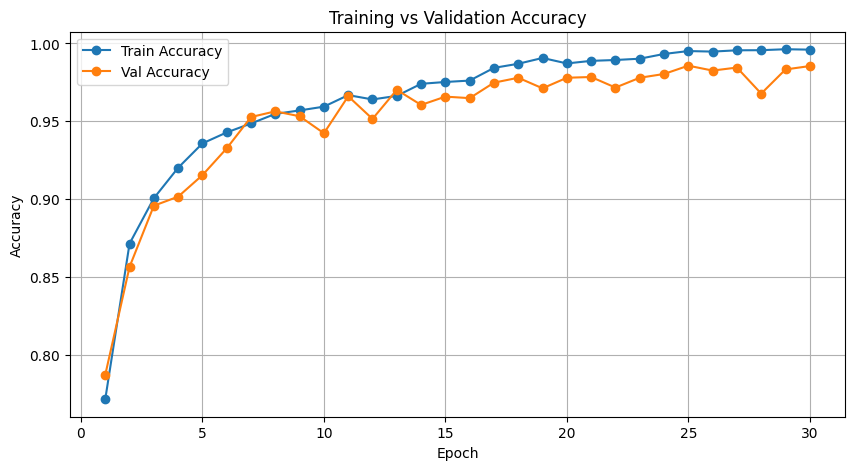

In [6]:

# Classification Report (includes per-class accuracy, precision, recall, f1)
report = classification_report(all_labels, all_preds, target_names=classes)
print("\n🧾 Classification Report:\n")
print(report)

# Optionally: Save it to a text file
with open("classification_report.txt", "w") as f:
    f.write(report)

# Plot Accuracy & Loss from CSV
df = pd.read_csv("logs/training_log.csv")

plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train_acc"], label="Train Accuracy", marker='o')
plt.plot(df["epoch"], df["val_acc"], label="Val Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


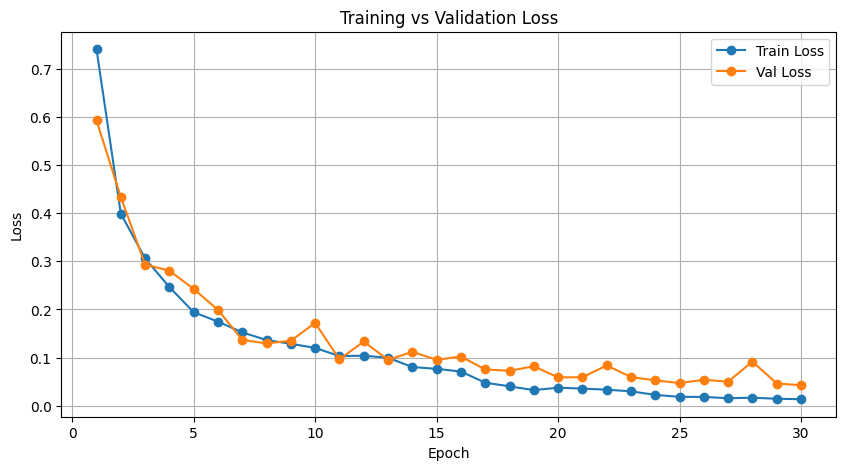

In [7]:

plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss", marker='o')
plt.plot(df["epoch"], df["val_loss"], label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
